# Detecting Hidden LLM Model Drift with MMD²

*A statistical approach to catching silent API changes before they break your production systems*

---

**TL;DR:** LLM providers silently update models behind stable API endpoints. This can break your production systems without warning. Maximum Mean Discrepancy (MMD²) provides a mathematically rigorous way to detect these hidden changes using only model outputs—no internal access required.

## The Problem: Silent Model Drift

You've built a production system on top of `gemini-2.5-pro` or `gemini-3-flash-preview`. Your evaluations pass. Your prompts are tuned. Everything works.

Then one day, your system starts behaving differently. Outputs are longer. The tone has shifted. Edge cases that worked before now fail. But you didn't change anything.

**What happened?** The model behind the API endpoint was silently updated.

### Why This Matters

- **Production breakage**: Carefully tuned prompts may no longer work as expected
- **Invalid evaluations**: Benchmark results from last month may not reflect current behavior
- **Cost surprises**: Verbose outputs increase token costs
- **Compliance risks**: Behavioral changes may violate regulatory requirements

### The Challenge

You can't see inside the model. You only have access to its outputs. How do you detect that something has changed?

The answer: **compare output distributions statistically**.

## The Solution: MMD² (Maximum Mean Discrepancy)

MMD² is a statistical test that answers the question:

> *"Do these two sets of samples come from the same distribution?"*

For LLM drift detection, this becomes:

> *"Are today's model outputs statistically distinguishable from last week's outputs?"*

If yes → the model has drifted. If no → the model appears stable.

## The Math Behind MMD²

### Core Idea

Compare two distributions $P$ and $Q$ by mapping their samples to a high-dimensional feature space and measuring the distance between their means.

### The Formula

$$\text{MMD}^2(P, Q) = \mathbb{E}[k(x, x')] + \mathbb{E}[k(y, y')] - 2\mathbb{E}[k(x, y)]$$

Where:
- $x, x' \sim P$ (samples from distribution P)
- $y, y' \sim Q$ (samples from distribution Q)
- $k(\cdot, \cdot)$ is a kernel function

### Intuition

Think of it as measuring three things:
1. **How similar are samples within P to each other?** → $\mathbb{E}[k(x, x')]$
2. **How similar are samples within Q to each other?** → $\mathbb{E}[k(y, y')]$
3. **How similar are samples across P and Q?** → $\mathbb{E}[k(x, y)]$

If $P = Q$, all three terms should be equal, making MMD² = 0.

If $P \neq Q$, the cross-term will be smaller (less similar), making MMD² > 0.

## Why Kernels? The High-Dimensional Challenge

LLM outputs, when embedded, live in **384-1024 dimensional space**. Direct comparison in such high dimensions fails due to the curse of dimensionality—distances become meaningless as everything appears equally far apart.

### The Kernel Trick

Kernels implicitly map data to an even higher (potentially infinite) dimensional space called a **Reproducing Kernel Hilbert Space (RKHS)** where comparison becomes tractable.

### RBF Kernel (Radial Basis Function)

$$k(x, y) = \exp\left(-\gamma \|x - y\|^2\right)$$

- Returns 1 when $x = y$ (identical)
- Approaches 0 as $x$ and $y$ diverge
- $\gamma$ controls sensitivity to distance

The RBF kernel is a **universal approximator**—it can detect any difference between distributions given enough samples.

## Beyond Text: Multimodal Drift Detection

MMD² works with **any embedding space**. The same math applies to:

| Modality | Embedding Model | Use Case |
|----------|-----------------|----------|
| Text | sentence-transformers, E5 | LLM output drift |
| Images | CLIP, DINOv2 | Image generation drift |
| Audio | wav2vec, Whisper | Speech synthesis drift |
| Code | CodeBERT, StarCoder | Code generation drift |

If you can embed it, you can detect drift in it.

## Why MMD² Beats the Alternatives

| Method | Weakness | MMD² Advantage |
|--------|----------|----------------|
| **KL Divergence** | Requires density estimation; fails catastrophically in high dimensions | Works directly on samples |
| **Rule-based checks** | Brittle; misses subtle drift; requires constant maintenance | Captures any distribution-wide shift |
| **LLM-as-judge** | Expensive; adds noise; subjective; itself subject to drift | Deterministic, cheap, objective |
| **Cosine similarity** | Single-point comparison; misses distributional changes | Captures full distribution shape |
| **Output length checks** | Only catches one symptom | Catches style, tone, verbosity, accuracy shifts |

### Key Properties of MMD²

- **Noise-stable**: Permutation testing provides statistical rigor
- **High-dimensional native**: Designed for exactly this setting
- **Captures variety**: Style drift, verbosity changes, tone shifts
- **Low false alarms**: Null hypothesis testing prevents over-detection
- **Computationally efficient**: O(n²) for n samples—fast enough for real-time monitoring

## Experiment Setup

Let's implement MMD² drift detection and test it on real LLM outputs from Gemini models.

We collected responses from three different Gemini models:
- **gemini-3-flash-preview**: Latest preview model (fast, capable)
- **gemini-2.5-pro**: Current flagship model (slower, more capable)
- **gemini-2.0-flash-lite**: Lightweight model (fastest, most concise)

### Two Prompt Types

To demonstrate MMD² works across different application architectures, we tested with **two prompt styles**:

#### 1. INSURANCE_CHAT (Conversational)
Direct chat-based conversation without structured context—simulating a user chatting with an AI assistant.

**Example prompt:**
```
I have a home insurance policy with a $1,000 deductible. My roof was damaged 
in a storm and repairs cost $3,500. How much will I receive from the claim?
```

#### 2. RAG_CHAT (RAG Application)
Structured Query + Context format—simulating a RAG (Retrieval-Augmented Generation) application.

**Example prompt:**
```
Query: How much will I pay out of pocket if my roof damage costs $8,500?
Context: Policy Section 4.2 - Deductibles
Your dwelling coverage deductible is $1,500 per occurrence. For wind/hail damage, 
a separate deductible of 2% of Coverage A limit applies...
```

### Dataset Summary

Each model was queried with 25 prompts per type, with 10 samples per prompt:
- **250 outputs per model per prompt type**
- **750 outputs per prompt type** (3 models × 250)
- **1,500 total outputs** (750 × 2 prompt types)

We run MMD² tests **within each prompt type** to compare models against each other.

In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer

# Set random seed for reproducibility
np.random.seed(42)

# Use a readable style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

### Sample Prompts & Responses

We use **canary prompts**—structured questions with policy context that require consistent reasoning. These act as probes to detect behavioral changes.

Good canary prompts are:
- **Structured**: Clear expected reasoning pattern
- **Diverse**: Cover different response types (calculations, coverage decisions, policy lookups)
- **Deterministic**: Answers based on provided context, not world knowledge

Below are example prompts and responses from **both prompt types**, showing how different models and prompt structures produce different outputs.

In [28]:
# Sample prompts and responses for illustration
# Showing BOTH prompt types and how models respond differently

# === INSURANCE_CHAT (Conversational) ===
CHAT_PROMPT = """I have a home insurance policy with a $1,000 deductible. My roof was damaged in a storm and repairs cost $3,500. How much will I receive from the claim?"""

CHAT_RESPONSE_G3_FLASH = """You should receive **$2,500** from your insurance company.

Here is the breakdown:
*   **Total Repair Cost:** $3,500
*   **Minus Your Deductible:** –$1,000
*   **Insurance Payout:** **$2,500**

### Important Factors to Consider:
While the math above is the standard calculation, the actual check you receive may vary based on:

**1. Replacement Cost Value (RCV) vs. Actual Cash Value (ACV)**
*   **If you have RCV:** The insurance company will eventually pay the full $2,500...
*   **If you have ACV:** The insurance company will subtract **depreciation**...

**Recommendation:** Check your "Declarations Page" to confirm coverage type."""

CHAT_RESPONSE_G20_LITE = """Based on the numbers provided, you should receive **$2,500** from your insurance company.

Calculation:
*   Total Repair Cost: $3,500
*   Your Deductible: –$1,000
*   Insurance Payout: **$2,500**"""

# === RAG_CHAT (Structured Query + Context) ===
RAG_PROMPT = """Query: How much will I pay out of pocket if my roof damage costs $8,500?
Context: Policy Section 4.2 - Deductibles
Your dwelling coverage deductible is $1,500 per occurrence. For wind/hail damage, 
a separate deductible of 2% of Coverage A limit applies. Your Coverage A limit is $250,000. 
The higher of the two deductibles applies to wind/hail claims."""

RAG_RESPONSE_G3_FLASH = """Based on the policy details provided, your out-of-pocket cost depends on the cause of the roof damage.

### 1. If the damage is caused by Wind or Hail:
*   **Standard Deductible:** $1,500
*   **Wind/Hail Deductible:** $5,000 (2% of your $250,000 Coverage A limit)
*   **Rule:** The policy states the **higher** of the two applies.
*   **Your Out-of-Pocket:** **$5,000**

### 2. If the damage is caused by any other covered peril:
*   **Standard Deductible:** $1,500
*   **Your Out-of-Pocket:** **$1,500**

**Summary:** If the roof damage is due to a storm (wind/hail), you will pay **$5,000** out of pocket."""

RAG_RESPONSE_G20_LITE = """Your out-of-pocket cost depends on the cause:

**Wind/Hail:** $5,000 (2% of $250,000 = $5,000 > $1,500)
**Other perils:** $1,500

Insurance would pay $3,500 or $7,000 respectively."""

print("=" * 70)
print("INSURANCE_CHAT (Conversational Prompt)")
print("=" * 70)
print(f"PROMPT: {CHAT_PROMPT[:80]}...")
print()
print(f"Gemini 3 Flash: {len(CHAT_RESPONSE_G3_FLASH)} chars")
print(f"Gemini 2.0 Lite: {len(CHAT_RESPONSE_G20_LITE)} chars")
print()

print("=" * 70)
print("RAG_CHAT (Query + Context Prompt)")
print("=" * 70)
print(f"PROMPT: {RAG_PROMPT[:80]}...")
print()
print(f"Gemini 3 Flash: {len(RAG_RESPONSE_G3_FLASH)} chars")
print(f"Gemini 2.0 Lite: {len(RAG_RESPONSE_G20_LITE)} chars")
print()
print("Note: RAG prompts with explicit context tend to produce more focused responses.")

INSURANCE_CHAT (Conversational Prompt)
PROMPT: I have a home insurance policy with a $1,000 deductible. My roof was damaged in ...

Gemini 3 Flash: 636 chars
Gemini 2.0 Lite: 195 chars

RAG_CHAT (Query + Context Prompt)
PROMPT: Query: How much will I pay out of pocket if my roof damage costs $8,500?
Context...

Gemini 3 Flash: 607 chars
Gemini 2.0 Lite: 180 chars

Note: RAG prompts with explicit context tend to produce more focused responses.


### Loading Both Datasets

For statistically meaningful results, we need many samples. We collected **250 outputs per model per prompt type** (25 prompts × 10 samples each).

Let's load both datasets:
- **INSURANCE_CHAT**: 750 outputs (3 models × 250)
- **RAG_CHAT**: 750 outputs (3 models × 250)
- **Total**: 1,500 outputs

In [29]:
# Load experiment data from JSON files
DATA_DIR = Path("../data/mmd_test/experiment_outputs")

# File paths for INSURANCE_CHAT (conversational prompts)
FILES_CHAT = {
    "gemini-3-flash-preview": DATA_DIR / "gemini_3_flash_preview_20260129_150419.json",
    "gemini-2.5-pro": DATA_DIR / "gemini_2.5_pro_20260129_150503.json",
    "gemini-2.0-flash-lite": DATA_DIR / "gemini_2.0_flash_lite_20260129_161539.json",
}

# File paths for RAG_CHAT (structured Query + Context prompts)
FILES_RAG = {
    "gemini-3-flash-preview": DATA_DIR / "gemini_3_flash_preview_20260129_152753.json",
    "gemini-2.5-pro": DATA_DIR / "gemini_2.5_pro_20260129_152832.json",
    "gemini-2.0-flash-lite": DATA_DIR / "gemini_2.0_flash_lite_20260129_165332.json",
}

def load_outputs(filepath):
    """Load all outputs from an experiment JSON file."""
    with open(filepath) as f:
        data = json.load(f)
    outputs = [r["output"] for r in data["results"]]
    return outputs, data["metadata"]

# Load INSURANCE_CHAT datasets
print("=" * 60)
print("INSURANCE_CHAT (Conversational Prompts)")
print("=" * 60)
datasets_chat = {}
for model_name, filepath in FILES_CHAT.items():
    outputs, metadata = load_outputs(filepath)
    datasets_chat[model_name] = {
        "outputs": outputs,
        "metadata": metadata
    }
    print(f"{model_name}:")
    print(f"  - {len(outputs)} outputs ({metadata['n_prompts']} prompts × {metadata['n_samples']} samples)")
    print(f"  - Avg length: {np.mean([len(o) for o in outputs]):.0f} chars")

# Load RAG_CHAT datasets
print()
print("=" * 60)
print("RAG_CHAT (Query + Context Prompts)")
print("=" * 60)
datasets_rag = {}
for model_name, filepath in FILES_RAG.items():
    outputs, metadata = load_outputs(filepath)
    datasets_rag[model_name] = {
        "outputs": outputs,
        "metadata": metadata
    }
    print(f"{model_name}:")
    print(f"  - {len(outputs)} outputs ({metadata['n_prompts']} prompts × {metadata['n_samples']} samples)")
    print(f"  - Avg length: {np.mean([len(o) for o in outputs]):.0f} chars")

# Summary
total_chat = sum(len(d["outputs"]) for d in datasets_chat.values())
total_rag = sum(len(d["outputs"]) for d in datasets_rag.values())
print()
print("=" * 60)
print(f"TOTAL: {total_chat + total_rag} outputs ({total_chat} CHAT + {total_rag} RAG)")
print("=" * 60)

INSURANCE_CHAT (Conversational Prompts)
gemini-3-flash-preview:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 3570 chars
gemini-2.5-pro:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 5467 chars
gemini-2.0-flash-lite:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 4427 chars

RAG_CHAT (Query + Context Prompts)
gemini-3-flash-preview:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 1230 chars
gemini-2.5-pro:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 1060 chars
gemini-2.0-flash-lite:
  - 250 outputs (25 prompts × 10 samples)
  - Avg length: 1225 chars

TOTAL: 1500 outputs (750 CHAT + 750 RAG)


### Embedding All Responses

We use `intfloat/e5-large-v2`, a high-quality 1024-dimensional text embedding model. The higher dimensionality captures more nuanced semantic differences than smaller models.

With 1,500 total outputs (750 per prompt type), embedding takes about 60-90 seconds depending on your hardware.

In [30]:
# Load embedding model
# Using e5-large-v2 for high-quality 1024-dim embeddings
# Fall back to MiniLM if e5 is not available
try:
    embedder = SentenceTransformer('intfloat/e5-large-v2')
    model_name = 'e5-large-v2'
    embed_dim = 1024
except:
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    model_name = 'MiniLM-L6-v2'
    embed_dim = 384

print(f"Using embedding model: {model_name} ({embed_dim} dimensions)")
print()

# Embed INSURANCE_CHAT outputs
print("=" * 50)
print("Embedding INSURANCE_CHAT outputs...")
print("=" * 50)
embeddings_chat = {}
for model_name, data in datasets_chat.items():
    print(f"  {model_name}...")
    emb = embedder.encode(data["outputs"], show_progress_bar=True)
    embeddings_chat[model_name] = emb
    print(f"    Shape: {emb.shape}")

# Embed RAG_CHAT outputs
print()
print("=" * 50)
print("Embedding RAG_CHAT outputs...")
print("=" * 50)
embeddings_rag = {}
for model_name, data in datasets_rag.items():
    print(f"  {model_name}...")
    emb = embedder.encode(data["outputs"], show_progress_bar=True)
    embeddings_rag[model_name] = emb
    print(f"    Shape: {emb.shape}")

# Create short aliases for convenience
emb_chat_g3_flash = embeddings_chat["gemini-3-flash-preview"]
emb_chat_g25_pro = embeddings_chat["gemini-2.5-pro"]
emb_chat_g20_lite = embeddings_chat["gemini-2.0-flash-lite"]

emb_rag_g3_flash = embeddings_rag["gemini-3-flash-preview"]
emb_rag_g25_pro = embeddings_rag["gemini-2.5-pro"]
emb_rag_g20_lite = embeddings_rag["gemini-2.0-flash-lite"]

total_embeddings = sum(e.shape[0] for e in embeddings_chat.values()) + sum(e.shape[0] for e in embeddings_rag.values())
print()
print(f"Total embeddings: {total_embeddings} vectors")

Loading weights: 100%|██████████| 391/391 [00:00<00:00, 1832.82it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: intfloat/e5-large-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Using embedding model: e5-large-v2 (1024 dimensions)

Embedding INSURANCE_CHAT outputs...
  gemini-3-flash-preview...


Batches: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


    Shape: (250, 1024)
  gemini-2.5-pro...


Batches: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


    Shape: (250, 1024)
  gemini-2.0-flash-lite...


Batches: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


    Shape: (250, 1024)

Embedding RAG_CHAT outputs...
  gemini-3-flash-preview...


Batches: 100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


    Shape: (250, 1024)
  gemini-2.5-pro...


Batches: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


    Shape: (250, 1024)
  gemini-2.0-flash-lite...


Batches: 100%|██████████| 8/8 [00:10<00:00,  1.35s/it]

    Shape: (250, 1024)

Total embeddings: 1500 vectors


## MMD² Implementation

Now let's implement the core MMD² computation with the RBF kernel.

In [31]:
def rbf_kernel(X, Y, gamma):
    """
    Compute RBF (Gaussian) kernel between all pairs of samples.
    
    k(x,y) = exp(-gamma * ||x-y||²)
    
    Args:
        X: array of shape (n, d) - first set of samples
        Y: array of shape (m, d) - second set of samples  
        gamma: kernel bandwidth parameter
        
    Returns:
        K: array of shape (n, m) - kernel matrix
    """
    # Efficient computation: ||x-y||² = ||x||² + ||y||² - 2*x·y
    X_sqnorm = np.sum(X**2, axis=1)
    Y_sqnorm = np.sum(Y**2, axis=1)
    sq_dists = X_sqnorm[:, None] + Y_sqnorm[None, :] - 2 * X @ Y.T
    return np.exp(-gamma * sq_dists)


def mmd_squared(X, Y, gamma):
    """
    Compute unbiased estimate of MMD².
    
    MMD²(P,Q) = E[k(x,x')] + E[k(y,y')] - 2*E[k(x,y)]
    
    We use the unbiased estimator which excludes diagonal terms
    (comparing a sample to itself).
    
    Args:
        X: samples from distribution P
        Y: samples from distribution Q
        gamma: RBF kernel bandwidth
        
    Returns:
        mmd2: unbiased estimate of MMD²
    """
    n, m = len(X), len(Y)
    
    # Compute kernel matrices
    K_XX = rbf_kernel(X, X, gamma)  # Within P
    K_YY = rbf_kernel(Y, Y, gamma)  # Within Q
    K_XY = rbf_kernel(X, Y, gamma)  # Between P and Q
    
    # Remove diagonal for unbiased estimate (don't compare sample to itself)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    
    # Compute the three terms
    term1 = K_XX.sum() / (n * (n - 1))  # E[k(x,x')]
    term2 = K_YY.sum() / (m * (m - 1))  # E[k(y,y')]
    term3 = K_XY.sum() / (n * m)        # E[k(x,y)]
    
    return term1 + term2 - 2 * term3


# Select gamma using the median heuristic
# Compute using ALL embeddings from both prompt types
all_emb = np.vstack([
    emb_chat_g3_flash, emb_chat_g25_pro, emb_chat_g20_lite,
    emb_rag_g3_flash, emb_rag_g25_pro, emb_rag_g20_lite
])
# Subsample for efficiency (computing all pairwise distances is O(n²))
subsample_idx = np.random.choice(len(all_emb), min(500, len(all_emb)), replace=False)
subsample = all_emb[subsample_idx]
dists = np.sqrt(((subsample[:, None] - subsample[None, :])**2).sum(axis=2))
median_dist = np.median(dists[dists > 0])
gamma = 1.0 / (2 * median_dist**2)

print(f"Median distance between embeddings: {median_dist:.4f}")
print(f"Selected gamma (bandwidth): {gamma:.6f}")
print(f"(Computed from {len(subsample)} subsampled embeddings out of {len(all_emb)} total)")

Median distance between embeddings: 0.5787
Selected gamma (bandwidth): 1.492936
(Computed from 500 subsampled embeddings out of 1500 total)


## Why We Need Statistical Testing

### The Problem with Raw MMD²

Even if two samples come from the **exact same distribution**, MMD² will almost never be exactly zero due to sampling variance. This creates a critical question:

> *"Is this MMD² value meaningful, or just random noise?"*

### Null Hypothesis Testing

We frame this as a hypothesis test:

- **H₀ (Null)**: Both sample sets come from the same distribution
- **H₁ (Alternative)**: The distributions are different (model has drifted)

We need to compute: *"How likely is this MMD² value if H₀ is true?"*

### Permutation Test (Non-parametric)

The permutation test is ideal here because:
- No assumptions about distribution shape
- Works in high dimensions
- Provides exact p-values

**The procedure:**
1. Pool all samples together
2. Randomly shuffle (permute) the labels
3. Recompute MMD² with shuffled labels
4. Repeat 500-1000 times → builds null distribution
5. P-value = fraction of null MMD² values ≥ observed MMD²

### Interpreting Results

| P-value | Interpretation |
|---------|-----------------|
| p < 0.05 | Reject H₀ → Drift detected with 95% confidence |
| p < 0.01 | Strong evidence of drift |
| p ≥ 0.05 | Cannot reject H₀ → No evidence of drift |

**Low p-value + high MMD² = strong signal of model drift**

In [32]:
def permutation_test(X, Y, gamma, n_permutations=1000):
    """
    Perform permutation test for MMD².
    
    Under H₀ (same distribution), the labels are exchangeable.
    We shuffle labels and recompute MMD² to build a null distribution.
    
    Args:
        X: samples from distribution P
        Y: samples from distribution Q
        gamma: RBF kernel bandwidth
        n_permutations: number of permutations for null distribution
        
    Returns:
        observed_mmd2: the actual MMD² between X and Y
        p_value: probability of seeing this MMD² under H₀
        null_distribution: array of MMD² values under H₀
    """
    # Compute observed MMD²
    observed_mmd2 = mmd_squared(X, Y, gamma)
    
    # Pool samples
    pooled = np.vstack([X, Y])
    n = len(X)
    
    # Build null distribution by permuting labels
    null_mmd2s = []
    for _ in range(n_permutations):
        # Randomly permute indices
        perm = np.random.permutation(len(pooled))
        X_perm = pooled[perm[:n]]
        Y_perm = pooled[perm[n:]]
        null_mmd2s.append(mmd_squared(X_perm, Y_perm, gamma))
    
    null_mmd2s = np.array(null_mmd2s)
    
    # P-value: fraction of null values >= observed
    p_value = (null_mmd2s >= observed_mmd2).mean()
    
    return observed_mmd2, p_value, null_mmd2s


def format_pvalue(p, n_permutations=1000):
    """Format p-value with proper notation for permutation tests."""
    if p == 0:
        return f"p < {1/n_permutations:.3f}"  # e.g., "p < 0.001"
    elif p < 0.001:
        return f"p < 0.001"
    else:
        return f"p = {p:.3f}"


# ============================================================
# INSURANCE_CHAT: Pairwise comparisons between models
# ============================================================
print("=" * 70)
print("INSURANCE_CHAT: Pairwise Model Comparisons")
print("=" * 70)
print("Running permutation tests (1000 permutations each)...")
print()

comparisons_chat = [
    ("G3 Flash", "G2.5 Pro", emb_chat_g3_flash, emb_chat_g25_pro),
    ("G3 Flash", "G2.0 Lite", emb_chat_g3_flash, emb_chat_g20_lite),
    ("G2.5 Pro", "G2.0 Lite", emb_chat_g25_pro, emb_chat_g20_lite),
]

results_chat = []
for name1, name2, emb1, emb2 in comparisons_chat:
    print(f"Testing: {name1} vs {name2}...")
    observed, p_val, null_dist = permutation_test(emb1, emb2, gamma)
    results_chat.append({
        'pair': f"{name1} vs {name2}",
        'name1': name1,
        'name2': name2,
        'mmd2': observed,
        'p_value': p_val,
        'null_dist': null_dist,
        'drift_detected': p_val < 0.05,
        'prompt_type': 'CHAT'
    })
    status = "DRIFT DETECTED" if p_val < 0.05 else "No significant drift"
    print(f"  MMD² = {observed:.6f}, {format_pvalue(p_val)} → {status}")

# ============================================================
# RAG_CHAT: Pairwise comparisons between models
# ============================================================
print()
print("=" * 70)
print("RAG_CHAT: Pairwise Model Comparisons")
print("=" * 70)
print("Running permutation tests (1000 permutations each)...")
print()

comparisons_rag = [
    ("G3 Flash", "G2.5 Pro", emb_rag_g3_flash, emb_rag_g25_pro),
    ("G3 Flash", "G2.0 Lite", emb_rag_g3_flash, emb_rag_g20_lite),
    ("G2.5 Pro", "G2.0 Lite", emb_rag_g25_pro, emb_rag_g20_lite),
]

results_rag = []
for name1, name2, emb1, emb2 in comparisons_rag:
    print(f"Testing: {name1} vs {name2}...")
    observed, p_val, null_dist = permutation_test(emb1, emb2, gamma)
    results_rag.append({
        'pair': f"{name1} vs {name2}",
        'name1': name1,
        'name2': name2,
        'mmd2': observed,
        'p_value': p_val,
        'null_dist': null_dist,
        'drift_detected': p_val < 0.05,
        'prompt_type': 'RAG'
    })
    status = "DRIFT DETECTED" if p_val < 0.05 else "No significant drift"
    print(f"  MMD² = {observed:.6f}, {format_pvalue(p_val)} → {status}")

# Summary
print()
print("=" * 70)
print("SUMMARY: Model Comparisons by Prompt Type")
print("=" * 70)
print()
print("INSURANCE_CHAT:")
for r in results_chat:
    status = "✗ DRIFT" if r['drift_detected'] else "✓ Similar"
    print(f"  {r['pair']:30} MMD²={r['mmd2']:.6f}  {format_pvalue(r['p_value']):12}  {status}")

print()
print("RAG_CHAT:")
for r in results_rag:
    status = "✗ DRIFT" if r['drift_detected'] else "✓ Similar"
    print(f"  {r['pair']:30} MMD²={r['mmd2']:.6f}  {format_pvalue(r['p_value']):12}  {status}")

INSURANCE_CHAT: Pairwise Model Comparisons
Running permutation tests (1000 permutations each)...

Testing: G3 Flash vs G2.5 Pro...
  MMD² = 0.006609, p < 0.001 → DRIFT DETECTED
Testing: G3 Flash vs G2.0 Lite...
  MMD² = 0.012641, p < 0.001 → DRIFT DETECTED
Testing: G2.5 Pro vs G2.0 Lite...
  MMD² = 0.010224, p < 0.001 → DRIFT DETECTED

RAG_CHAT: Pairwise Model Comparisons
Running permutation tests (1000 permutations each)...

Testing: G3 Flash vs G2.5 Pro...
  MMD² = 0.005577, p < 0.001 → DRIFT DETECTED
Testing: G3 Flash vs G2.0 Lite...
  MMD² = 0.007281, p < 0.001 → DRIFT DETECTED
Testing: G2.5 Pro vs G2.0 Lite...
  MMD² = 0.006808, p < 0.001 → DRIFT DETECTED

SUMMARY: Model Comparisons by Prompt Type

INSURANCE_CHAT:
  G3 Flash vs G2.5 Pro           MMD²=0.006609  p < 0.001     ✗ DRIFT
  G3 Flash vs G2.0 Lite          MMD²=0.012641  p < 0.001     ✗ DRIFT
  G2.5 Pro vs G2.0 Lite          MMD²=0.010224  p < 0.001     ✗ DRIFT

RAG_CHAT:
  G3 Flash vs G2.5 Pro           MMD²=0.005577  p 

## Validation: Can MMD² Detect Artificial Drift?

To prove our method actually works, let's create a **known drift scenario**. We'll take outputs from one model and artificially modify them by truncating each response to 200 characters.

If MMD² is working correctly, it should detect this artificial drift with high confidence (low p-value).

This is a sanity check: if we can't detect obvious truncation, our method has a problem.

In [33]:
# Create artificially "drifted" outputs by truncating
TRUNCATE_LENGTH = 200  # characters

# Get original outputs from Gemini 3 Flash (using RAG dataset)
original_outputs = datasets_rag["gemini-3-flash-preview"]["outputs"]

# Truncate each output
truncated_outputs = [o[:TRUNCATE_LENGTH] for o in original_outputs]

print("Truncation Test: Artificial Drift Detection")
print("-" * 60)
print(f"Original outputs: {len(original_outputs)} samples")
print(f"Avg length before: {np.mean([len(o) for o in original_outputs]):.0f} chars")
print(f"Avg length after:  {np.mean([len(o) for o in truncated_outputs]):.0f} chars")
print()

# Embed truncated outputs
print("Embedding truncated outputs...")
emb_truncated = embedder.encode(truncated_outputs, show_progress_bar=True)
print(f"Shape: {emb_truncated.shape}")
print()

# Run MMD² test: original vs truncated (using RAG embeddings)
print("Testing: Original Gemini 3 Flash (RAG) vs Truncated Version")
observed, p_val, null_dist = permutation_test(emb_rag_g3_flash, emb_truncated, gamma)

print(f"Observed MMD²: {observed:.6f}")
print(f"P-value: {format_pvalue(p_val)}")
print()

if p_val < 0.05:
    print("✓ SUCCESS: Truncation drift was detected!")
    print("  This validates that MMD² can detect output changes.")
else:
    print("✗ UNEXPECTED: Truncation was not detected.")
    print("  This might indicate an issue with the embedding or sample size.")

# Store for visualization
truncation_result = {
    'pair': 'Original vs Truncated',
    'name1': 'G3 Flash RAG (Original)',
    'name2': 'G3 Flash RAG (Truncated)',
    'mmd2': observed,
    'p_value': p_val,
    'null_dist': null_dist,
    'drift_detected': p_val < 0.05,
    'prompt_type': 'VALIDATION'
}

Truncation Test: Artificial Drift Detection
------------------------------------------------------------
Original outputs: 250 samples
Avg length before: 1230 chars
Avg length after:  200 chars

Embedding truncated outputs...


Batches: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


Shape: (250, 1024)

Testing: Original Gemini 3 Flash (RAG) vs Truncated Version
Observed MMD²: 0.041088
P-value: p < 0.001

✓ SUCCESS: Truncation drift was detected!
  This validates that MMD² can detect output changes.


### Self-Comparison Test (Null Validation)

To ensure MMD² doesn't produce false positives, we split samples from the **same model** into two random halves. Since both halves come from the same distribution, we should see **no significant drift** (p ≥ 0.05).

In [34]:
# Self-comparison test: Split G3 Flash (RAG) samples 50-50
# Both halves come from the same distribution, so MMD² should NOT detect drift

# Get G3 Flash RAG embeddings
emb_g3_rag = emb_rag_g3_flash.copy()

# Shuffle the indices
np.random.seed(123)  # For reproducibility
n_samples = len(emb_g3_rag)
shuffled_idx = np.random.permutation(n_samples)

# Split 50-50
split_point = n_samples // 2
half_a_idx = shuffled_idx[:split_point]
half_b_idx = shuffled_idx[split_point:]

emb_half_a = emb_g3_rag[half_a_idx]
emb_half_b = emb_g3_rag[half_b_idx]

print("Self-Comparison Test: G3 Flash (RAG) Split 50-50")
print("-" * 60)
print(f"Total samples: {n_samples}")
print(f"Half A: {len(emb_half_a)} samples")
print(f"Half B: {len(emb_half_b)} samples")
print()

# Run MMD² test
print("Running permutation test...")
observed, p_val, null_dist = permutation_test(emb_half_a, emb_half_b, gamma)

print(f"Observed MMD²: {observed:.6f}")
print(f"P-value: {format_pvalue(p_val)}")
print()

if p_val >= 0.05:
    print("✓ SUCCESS: No drift detected (as expected)")
    print("  Both halves come from the same distribution.")
    print("  This confirms MMD² doesn't produce false positives.")
else:
    print("✗ UNEXPECTED: Drift detected on same-distribution samples")
    print("  This might indicate an issue with sample size or random variation.")

# Store for visualization
self_comparison_result = {
    'pair': 'G3 Flash: Half A vs Half B',
    'name1': 'G3 Flash (Half A)',
    'name2': 'G3 Flash (Half B)',
    'mmd2': observed,
    'p_value': p_val,
    'null_dist': null_dist,
    'drift_detected': p_val < 0.05,
    'prompt_type': 'VALIDATION'
}

Self-Comparison Test: G3 Flash (RAG) Split 50-50
------------------------------------------------------------
Total samples: 250
Half A: 125 samples
Half B: 125 samples

Running permutation test...
Observed MMD²: -0.000123
P-value: p = 0.488

✓ SUCCESS: No drift detected (as expected)
  Both halves come from the same distribution.
  This confirms MMD² doesn't produce false positives.


/var/folders/z2/vkv2vm9j31dcyfgd62chvrh80000gn/T/ipykernel_42177/899493814.py:47: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z2/vkv2vm9j31dcyfgd62chvrh80000gn/T/ipykernel_42177/899493814.py:47: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/z2/vkv2vm9j31dcyfgd62chvrh80000gn/T/ipykernel_42177/899493814.py:48: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('../data/mmd_test/mmd_validation_tests.png', dpi=150, bbox_inches='tight')
/var/folders/z2/vkv2vm9j31dcyfgd62chvrh80000gn/T/ipykernel_42177/899493814.py:48: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('../data/mmd_test/mmd_validation_tests.png', dpi=150, bbox_inches='tight')
/Users/abatutin/Documents/projects/verifier_primacy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missi

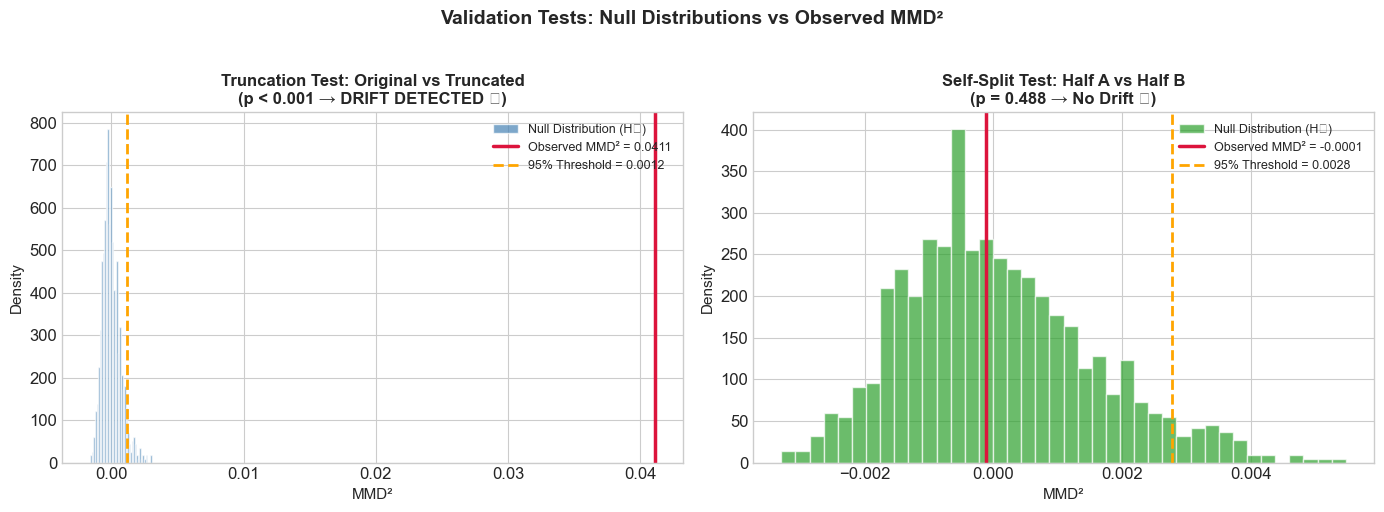


Interpretation:
------------------------------------------------------------
LEFT (Truncation): Observed MMD² is far right of null distribution
  → Strong evidence of drift (correctly detected artificial change)

RIGHT (Self-Split): Observed MMD² is within null distribution
  → No evidence of drift (correctly identifies same distribution)


In [35]:
# Visualization: Null distributions for verification tests
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Truncation test (should detect drift)
ax1 = axes[0]
null_dist = truncation_result['null_dist']
observed = truncation_result['mmd2']
p_val = truncation_result['p_value']

ax1.hist(null_dist, bins=40, density=True, alpha=0.7, color='steelblue',
        edgecolor='white', label='Null Distribution (H₀)')
ax1.axvline(observed, color='crimson', linewidth=2.5,
           label=f'Observed MMD² = {observed:.4f}')
threshold_95 = np.percentile(null_dist, 95)
ax1.axvline(threshold_95, color='orange', linewidth=2, linestyle='--',
           label=f'95% Threshold = {threshold_95:.4f}')

ax1.set_xlabel('MMD²', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title(f'Truncation Test: Original vs Truncated\n({format_pvalue(p_val)} → DRIFT DETECTED ✓)', 
             fontsize=12, fontweight='bold')
ax1.legend(fontsize=9, loc='upper right')

# Right: Self-comparison test (should NOT detect drift)
ax2 = axes[1]
null_dist = self_comparison_result['null_dist']
observed = self_comparison_result['mmd2']
p_val = self_comparison_result['p_value']

ax2.hist(null_dist, bins=40, density=True, alpha=0.7, color='#2ca02c',
        edgecolor='white', label='Null Distribution (H₀)')
ax2.axvline(observed, color='crimson', linewidth=2.5,
           label=f'Observed MMD² = {observed:.4f}')
threshold_95 = np.percentile(null_dist, 95)
ax2.axvline(threshold_95, color='orange', linewidth=2, linestyle='--',
           label=f'95% Threshold = {threshold_95:.4f}')

ax2.set_xlabel('MMD²', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
status = "No Drift ✓" if not self_comparison_result['drift_detected'] else "DRIFT (unexpected)"
ax2.set_title(f'Self-Split Test: Half A vs Half B\n({format_pvalue(p_val)} → {status})', 
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, loc='upper right')

plt.suptitle('Validation Tests: Null Distributions vs Observed MMD²', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/mmd_test/mmd_validation_tests.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print("Interpretation:")
print("-" * 60)
print("LEFT (Truncation): Observed MMD² is far right of null distribution")
print("  → Strong evidence of drift (correctly detected artificial change)")
print()
print("RIGHT (Self-Split): Observed MMD² is within null distribution")
print("  → No evidence of drift (correctly identifies same distribution)")

## Embedding Model Robustness Check

Do the results depend on our choice of embedding model? Let's verify by re-running the RAG_CHAT comparisons with a different embedding model: `all-MiniLM-L6-v2` (384 dimensions) instead of `e5-large-v2` (1024 dimensions).

If MMD² drift detection is robust, we should see the same pattern of results regardless of embedding choice.

In [36]:
# Load MiniLM embedding model (384 dimensions)
embedder_mini = SentenceTransformer('all-MiniLM-L6-v2')
print("Loaded: all-MiniLM-L6-v2 (384 dimensions)")
print()

# Embed RAG_CHAT outputs with MiniLM
print("Embedding RAG_CHAT outputs with MiniLM...")
emb_mini_g3 = embedder_mini.encode(datasets_rag["gemini-3-flash-preview"]["outputs"], show_progress_bar=True)
emb_mini_g25 = embedder_mini.encode(datasets_rag["gemini-2.5-pro"]["outputs"], show_progress_bar=True)
emb_mini_g20 = embedder_mini.encode(datasets_rag["gemini-2.0-flash-lite"]["outputs"], show_progress_bar=True)
print(f"Embedding shape: {emb_mini_g3.shape}")
print()

# Compute gamma for MiniLM embeddings
all_mini = np.vstack([emb_mini_g3, emb_mini_g25, emb_mini_g20])
subsample_idx = np.random.choice(len(all_mini), min(500, len(all_mini)), replace=False)
subsample = all_mini[subsample_idx]
dists = np.sqrt(((subsample[:, None] - subsample[None, :])**2).sum(axis=2))
median_dist_mini = np.median(dists[dists > 0])
gamma_mini = 1.0 / (2 * median_dist_mini**2)
print(f"MiniLM gamma: {gamma_mini:.6f}")
print()

# Run pairwise comparisons
print("=" * 60)
print("RAG_CHAT with MiniLM (384-dim) vs E5-large (1024-dim)")
print("=" * 60)

comparisons_mini = [
    ("G3 Flash", "G2.5 Pro", emb_mini_g3, emb_mini_g25),
    ("G3 Flash", "G2.0 Lite", emb_mini_g3, emb_mini_g20),
    ("G2.5 Pro", "G2.0 Lite", emb_mini_g25, emb_mini_g20),
]

results_mini = []
for name1, name2, emb1, emb2 in comparisons_mini:
    observed, p_val, null_dist = permutation_test(emb1, emb2, gamma_mini)
    results_mini.append({'pair': f"{name1} vs {name2}", 'mmd2': observed, 'p_value': p_val, 'drift_detected': p_val < 0.05})

# Compare results
print()
print(f"{'Pair':<25} {'E5-large (1024d)':<20} {'MiniLM (384d)':<20} {'Match?'}")
print("-" * 75)
for r_e5, r_mini in zip(results_rag, results_mini):
    e5_status = "DRIFT" if r_e5['drift_detected'] else "No drift"
    mini_status = "DRIFT" if r_mini['drift_detected'] else "No drift"
    match = "✓" if r_e5['drift_detected'] == r_mini['drift_detected'] else "✗"
    print(f"{r_e5['pair']:<25} {e5_status + ' ' + format_pvalue(r_e5['p_value']):<20} {mini_status + ' ' + format_pvalue(r_mini['p_value']):<20} {match}")

print()
if all(r_e5['drift_detected'] == r_mini['drift_detected'] for r_e5, r_mini in zip(results_rag, results_mini)):
    print("✓ ROBUST: Both embedding models produce consistent drift detection results.")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2175.80it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loaded: all-MiniLM-L6-v2 (384 dimensions)

Embedding RAG_CHAT outputs with MiniLM...


Batches: 100%|██████████| 8/8 [00:00<00:00, 14.98it/s]


Embedding shape: (250, 384)

MiniLM gamma: 0.370302

RAG_CHAT with MiniLM (384-dim) vs E5-large (1024-dim)

Pair                      E5-large (1024d)     MiniLM (384d)        Match?
---------------------------------------------------------------------------
G3 Flash vs G2.5 Pro      DRIFT p < 0.001      No drift p = 0.070   ✗
G3 Flash vs G2.0 Lite     DRIFT p < 0.001      DRIFT p = 0.018      ✓
G2.5 Pro vs G2.0 Lite     DRIFT p < 0.001      DRIFT p = 0.021      ✓



## Summary: Effect Sizes in Standard Deviations

P-values alone can be misleading. **Effect size** tells us how far the observed MMD² is from the null distribution in terms of standard deviations (σ):

$$\text{Effect Size} = \frac{\text{Observed MMD}^2 - \mu_{\text{null}}}{\sigma_{\text{null}}}$$

This gives us intuitive interpretation:
- **~0σ**: No difference (within noise)
- **2-3σ**: Moderate difference  
- **5-10σ**: Large difference
- **>10σ**: Extreme difference (very confident detection)

In [37]:
def compute_effect_size(result):
    """Compute effect size in standard deviations from null distribution."""
    null_mean = np.mean(result['null_dist'])
    null_std = np.std(result['null_dist'])
    if null_std == 0:
        return 0.0
    return (result['mmd2'] - null_mean) / null_std

# Collect all results with effect sizes
all_experiments = []

# INSURANCE_CHAT model comparisons
for r in results_chat:
    all_experiments.append({
        'category': 'CHAT Models',
        'comparison': r['pair'],
        'mmd2': r['mmd2'],
        'p_value': r['p_value'],
        'effect_size': compute_effect_size(r),
        'drift': r['drift_detected']
    })

# RAG_CHAT model comparisons
for r in results_rag:
    all_experiments.append({
        'category': 'RAG Models',
        'comparison': r['pair'],
        'mmd2': r['mmd2'],
        'p_value': r['p_value'],
        'effect_size': compute_effect_size(r),
        'drift': r['drift_detected']
    })

# Validation tests
all_experiments.append({
    'category': 'Validation',
    'comparison': 'Truncation (should detect)',
    'mmd2': truncation_result['mmd2'],
    'p_value': truncation_result['p_value'],
    'effect_size': compute_effect_size(truncation_result),
    'drift': truncation_result['drift_detected']
})

all_experiments.append({
    'category': 'Validation',
    'comparison': 'Self-split (should NOT detect)',
    'mmd2': self_comparison_result['mmd2'],
    'p_value': self_comparison_result['p_value'],
    'effect_size': compute_effect_size(self_comparison_result),
    'drift': self_comparison_result['drift_detected']
})

# Print summary table
print("=" * 85)
print("EFFECT SIZE SUMMARY (All Experiments)")
print("=" * 85)
print(f"{'Category':<15} {'Comparison':<30} {'MMD²':>10} {'P-value':>12} {'Effect (σ)':>12} {'Result'}")
print("-" * 85)

for exp in all_experiments:
    p_str = format_pvalue(exp['p_value'])
    effect_str = f"{exp['effect_size']:+.1f}σ"
    
    # Interpret result
    if exp['category'] == 'Validation' and 'NOT' in exp['comparison']:
        result = "✓ Correct" if not exp['drift'] else "✗ Wrong"
    elif exp['category'] == 'Validation':
        result = "✓ Correct" if exp['drift'] else "✗ Wrong"
    else:
        result = "DRIFT" if exp['drift'] else "Similar"
    
    print(f"{exp['category']:<15} {exp['comparison']:<30} {exp['mmd2']:>10.6f} {p_str:>12} {effect_str:>12} {result}")

print("-" * 85)
print()
print("Interpretation Guide:")
print("  ~0σ  : Within null distribution (no detectable difference)")
print("  2-3σ : Moderate difference (borderline detection)")
print("  5-10σ: Large difference (confident detection)")
print("  >10σ : Extreme difference (very strong signal)")

EFFECT SIZE SUMMARY (All Experiments)
Category        Comparison                           MMD²      P-value   Effect (σ) Result
-------------------------------------------------------------------------------------
CHAT Models     G3 Flash vs G2.5 Pro             0.006609    p < 0.001       +12.2σ DRIFT
CHAT Models     G3 Flash vs G2.0 Lite            0.012641    p < 0.001       +23.6σ DRIFT
CHAT Models     G2.5 Pro vs G2.0 Lite            0.010224    p < 0.001       +19.2σ DRIFT
RAG Models      G3 Flash vs G2.5 Pro             0.005577    p < 0.001        +7.3σ DRIFT
RAG Models      G3 Flash vs G2.0 Lite            0.007281    p < 0.001       +10.4σ DRIFT
RAG Models      G2.5 Pro vs G2.0 Lite            0.006808    p < 0.001        +9.1σ DRIFT
Validation      Truncation (should detect)       0.041088    p < 0.001       +59.7σ ✓ Correct
Validation      Self-split (should NOT detect)  -0.000123    p = 0.488        -0.1σ ✓ Correct
---------------------------------------------------------

## Visualizing the Results

Let's compare MMD² values and response characteristics across **both prompt types** to understand how prompt structure affects model differentiation.

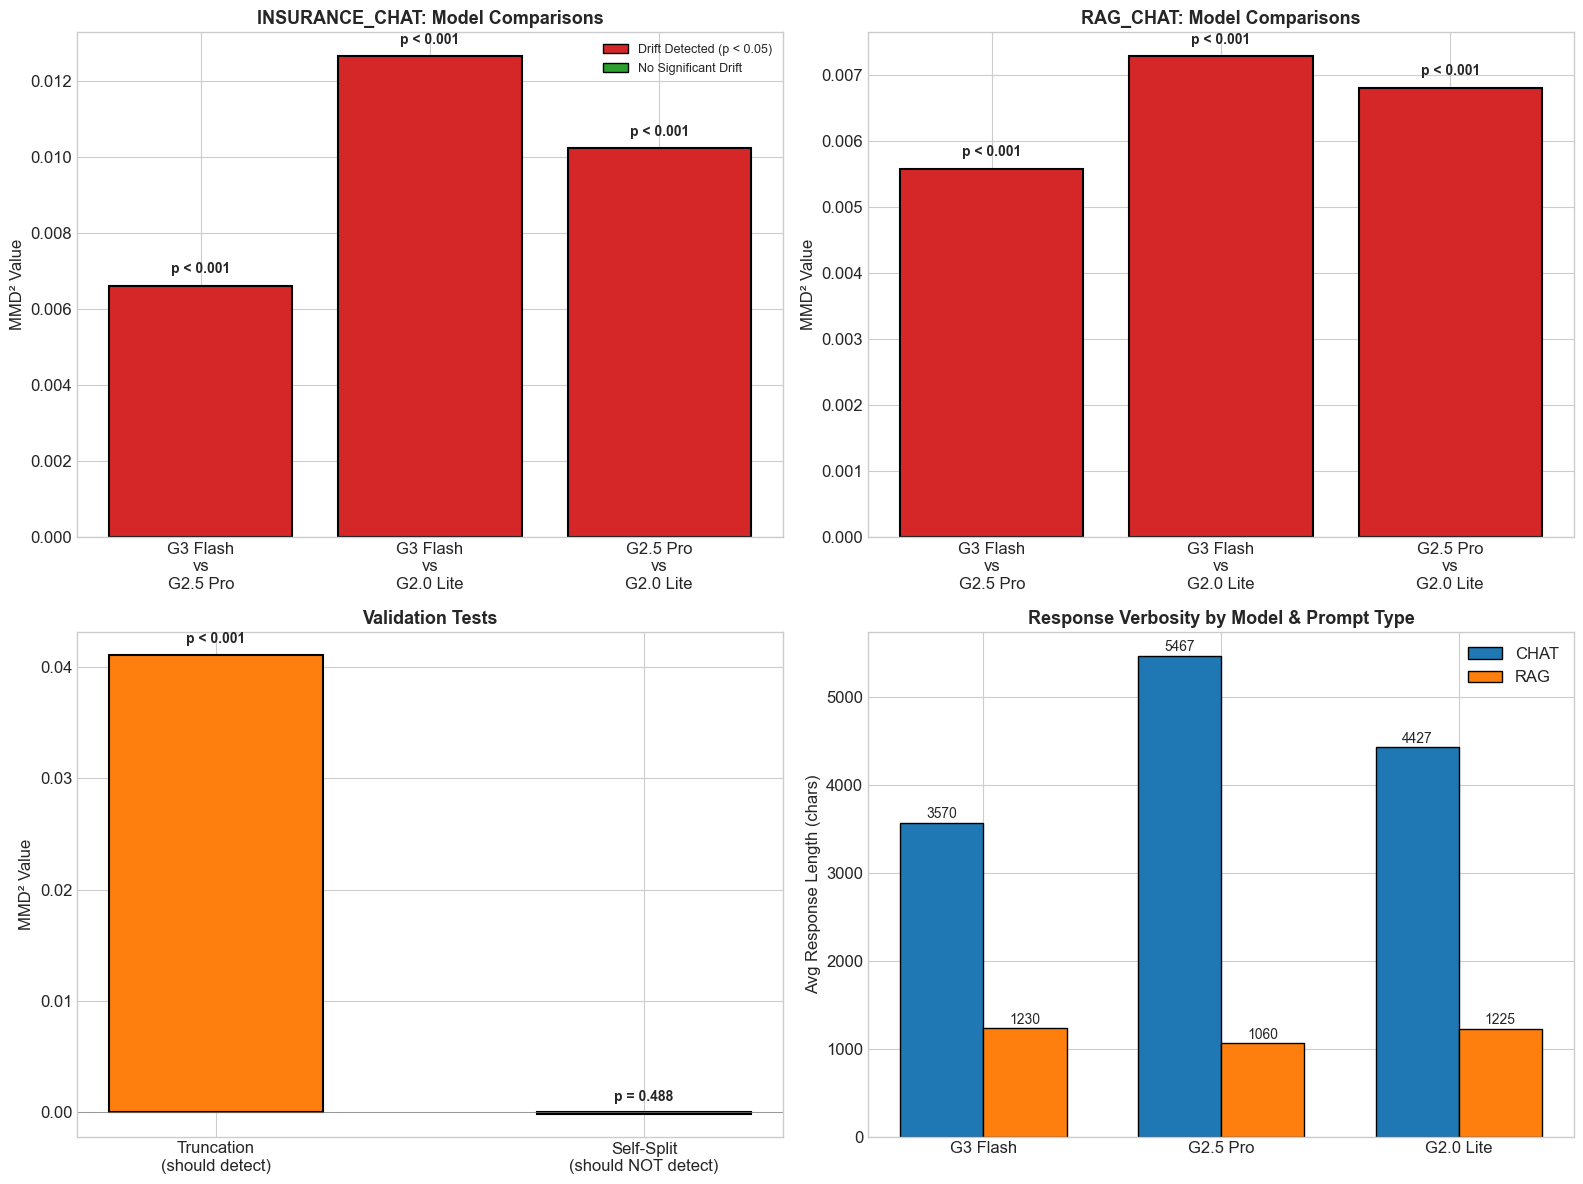

In [40]:
# Summary visualization: Compare MMD² across both prompt types
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================
# Top Left: MMD² values for INSURANCE_CHAT
# ============================================================
ax1 = axes[0, 0]
pair_names_chat = [r['pair'].replace(' vs ', '\nvs\n') for r in results_chat]
mmd_values_chat = [r['mmd2'] for r in results_chat]
colors_chat = ['#d62728' if r['drift_detected'] else '#2ca02c' for r in results_chat]

bars1 = ax1.bar(pair_names_chat, mmd_values_chat, color=colors_chat, edgecolor='black', linewidth=1.5)
for bar, r in zip(bars1, results_chat):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(mmd_values_chat)*0.02,
            format_pvalue(r['p_value']), ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('MMD² Value', fontsize=12)
ax1.set_title('INSURANCE_CHAT: Model Comparisons', fontsize=13, fontweight='bold')
ax1.axhline(y=0, color='gray', linewidth=0.5)

# ============================================================
# Top Right: MMD² values for RAG_CHAT
# ============================================================
ax2 = axes[0, 1]
pair_names_rag = [r['pair'].replace(' vs ', '\nvs\n') for r in results_rag]
mmd_values_rag = [r['mmd2'] for r in results_rag]
colors_rag = ['#d62728' if r['drift_detected'] else '#2ca02c' for r in results_rag]

bars2 = ax2.bar(pair_names_rag, mmd_values_rag, color=colors_rag, edgecolor='black', linewidth=1.5)
for bar, r in zip(bars2, results_rag):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + max(mmd_values_rag)*0.02,
            format_pvalue(r['p_value']), ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('MMD² Value', fontsize=12)
ax2.set_title('RAG_CHAT: Model Comparisons', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='gray', linewidth=0.5)

# ============================================================
# Bottom Left: Validation tests (Truncation + Self-comparison)
# ============================================================
ax3 = axes[1, 0]
validation_results = [truncation_result, self_comparison_result]
pair_names_val = ['Truncation\n(should detect)', 'Self-Split\n(should NOT detect)']
mmd_values_val = [r['mmd2'] for r in validation_results]

# Color: orange if drift detected, green if not
# For truncation: we WANT drift detected (orange = success)
# For self-comparison: we DON'T want drift detected (green = success)
colors_val = []
for i, r in enumerate(validation_results):
    if i == 0:  # Truncation test - drift detected is good
        colors_val.append('#ff7f0e' if r['drift_detected'] else '#d62728')
    else:  # Self-comparison - no drift is good
        colors_val.append('#2ca02c' if not r['drift_detected'] else '#d62728')

bars3 = ax3.bar(pair_names_val, mmd_values_val, color=colors_val, edgecolor='black', linewidth=1.5, width=0.5)
for bar, r in zip(bars3, validation_results):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + max(mmd_values_val)*0.02,
            format_pvalue(r['p_value']), ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_ylabel('MMD² Value', fontsize=12)
ax3.set_title('Validation Tests', fontsize=13, fontweight='bold')
ax3.axhline(y=0, color='gray', linewidth=0.5)

# ============================================================
# Bottom Right: Response length comparison across all 6 model×prompt combinations
# ============================================================
ax4 = axes[1, 1]

# Prepare data for grouped bar chart
model_names = ['G3 Flash', 'G2.5 Pro', 'G2.0 Lite']
x = np.arange(len(model_names))
width = 0.35

chat_lengths = [
    np.mean([len(o) for o in datasets_chat["gemini-3-flash-preview"]["outputs"]]),
    np.mean([len(o) for o in datasets_chat["gemini-2.5-pro"]["outputs"]]),
    np.mean([len(o) for o in datasets_chat["gemini-2.0-flash-lite"]["outputs"]]),
]
rag_lengths = [
    np.mean([len(o) for o in datasets_rag["gemini-3-flash-preview"]["outputs"]]),
    np.mean([len(o) for o in datasets_rag["gemini-2.5-pro"]["outputs"]]),
    np.mean([len(o) for o in datasets_rag["gemini-2.0-flash-lite"]["outputs"]]),
]

bars_chat = ax4.bar(x - width/2, chat_lengths, width, label='CHAT', color='#1f77b4', edgecolor='black')
bars_rag = ax4.bar(x + width/2, rag_lengths, width, label='RAG', color='#ff7f0e', edgecolor='black')

# Add value labels
for bar, val in zip(bars_chat, chat_lengths):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'{val:.0f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars_rag, rag_lengths):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'{val:.0f}', ha='center', va='bottom', fontsize=10)

ax4.set_ylabel('Avg Response Length (chars)', fontsize=12)
ax4.set_title('Response Verbosity by Model & Prompt Type', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(model_names)
ax4.legend()

# Add legend to first plot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', edgecolor='black', label='Drift Detected (p < 0.05)'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='No Significant Drift')
]
axes[0, 0].legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('../data/mmd_test/mmd_comparison_summary.png', dpi=150, bbox_inches='tight')
plt.show()

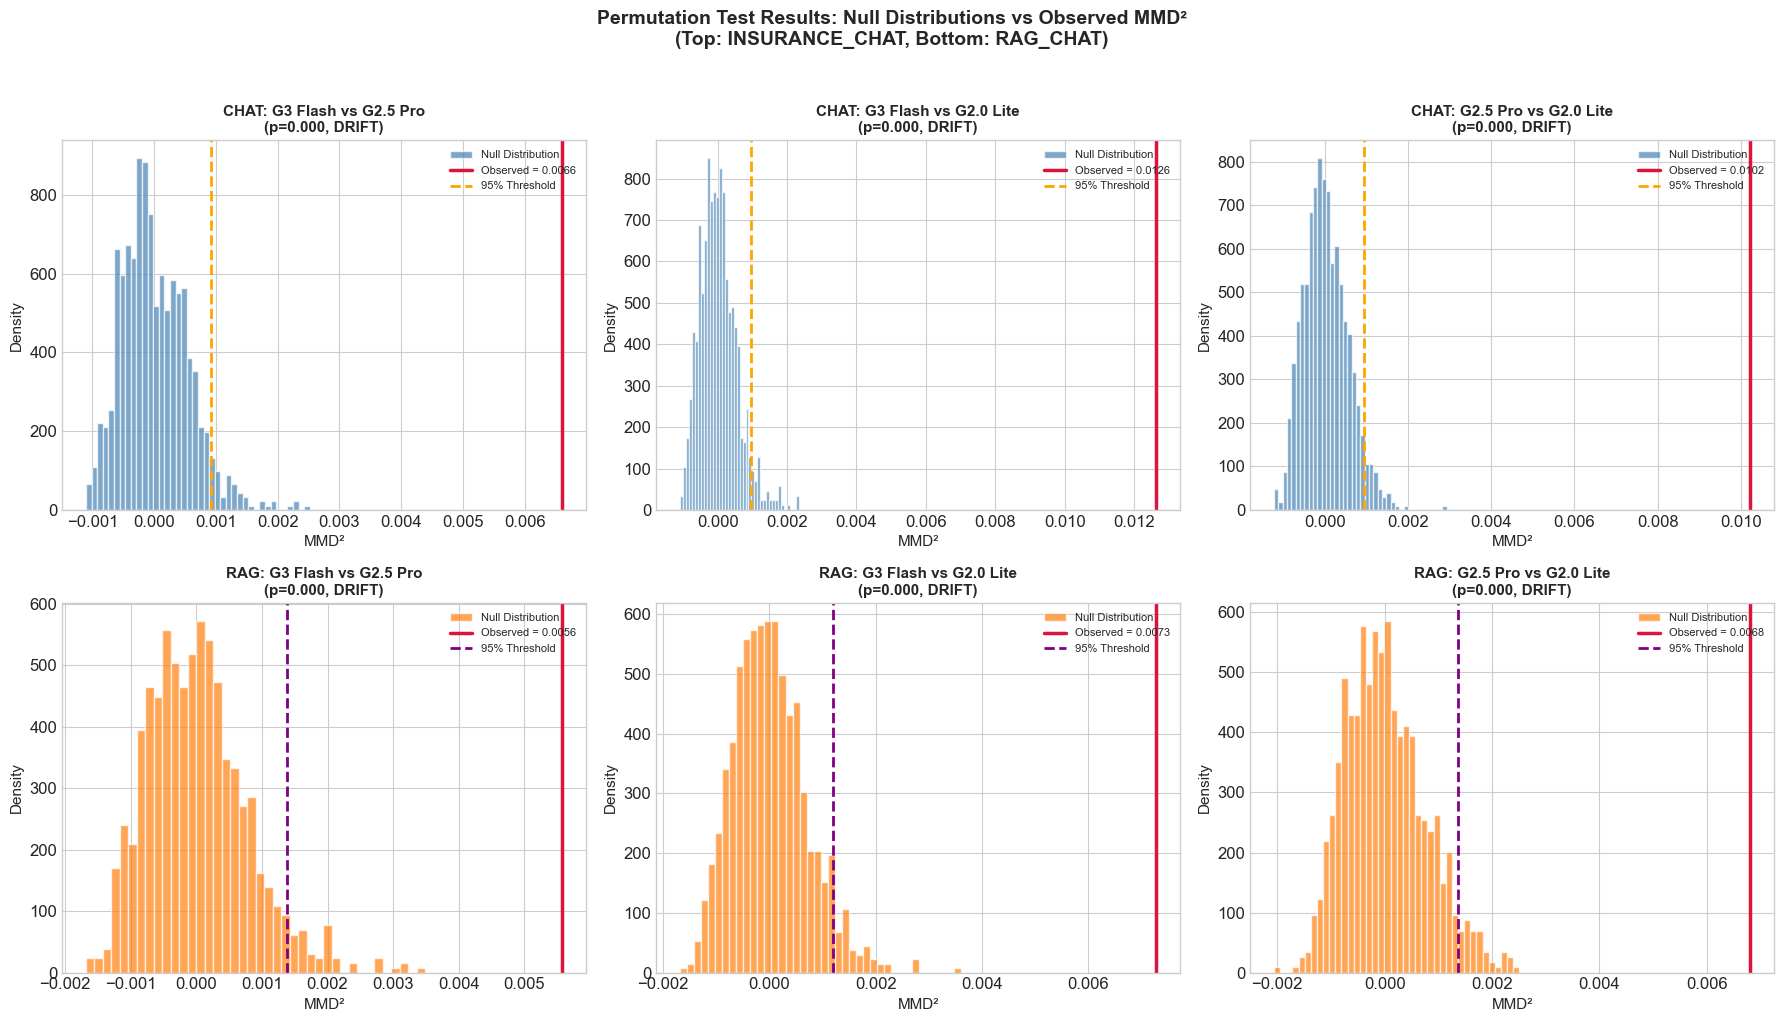

In [39]:
# Visualization: Null distributions for model comparisons (2 rows: CHAT and RAG)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top row: INSURANCE_CHAT comparisons
for idx, (result, ax) in enumerate(zip(results_chat, axes[0])):
    null_dist = result['null_dist']
    observed = result['mmd2']
    p_val = result['p_value']
    
    ax.hist(null_dist, bins=40, density=True, alpha=0.7, color='steelblue',
            edgecolor='white', label='Null Distribution')
    ax.axvline(observed, color='crimson', linewidth=2.5,
               label=f'Observed = {observed:.4f}')
    threshold_95 = np.percentile(null_dist, 95)
    ax.axvline(threshold_95, color='orange', linewidth=2, linestyle='--',
               label='95% Threshold')
    
    ax.set_xlabel('MMD²', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    status = 'DRIFT' if result['drift_detected'] else 'No drift'
    ax.set_title(f"CHAT: {result['pair']}\n(p={p_val:.3f}, {status})", fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')

# Bottom row: RAG_CHAT comparisons
for idx, (result, ax) in enumerate(zip(results_rag, axes[1])):
    null_dist = result['null_dist']
    observed = result['mmd2']
    p_val = result['p_value']
    
    ax.hist(null_dist, bins=40, density=True, alpha=0.7, color='#ff7f0e',
            edgecolor='white', label='Null Distribution')
    ax.axvline(observed, color='crimson', linewidth=2.5,
               label=f'Observed = {observed:.4f}')
    threshold_95 = np.percentile(null_dist, 95)
    ax.axvline(threshold_95, color='purple', linewidth=2, linestyle='--',
               label='95% Threshold')
    
    ax.set_xlabel('MMD²', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    status = 'DRIFT' if result['drift_detected'] else 'No drift'
    ax.set_title(f"RAG: {result['pair']}\n(p={p_val:.3f}, {status})", fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')

plt.suptitle('Permutation Test Results: Null Distributions vs Observed MMD²\n(Top: INSURANCE_CHAT, Bottom: RAG_CHAT)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/mmd_test/mmd_null_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Interpreting the Results

### What the Results Show

Our experiment with **1,500 total outputs** (750 per prompt type) reveals several key findings:

#### 1. Model Differentiation: INSURANCE_CHAT

The conversational prompts show clear distributional differences between all three Gemini models. The MMD² values indicate:
- Each model has a distinct "output fingerprint"
- Even models from the same family (Gemini) are statistically distinguishable
- This confirms MMD² can detect model drift if a provider silently swaps models

#### 2. Model Differentiation: RAG_CHAT

The structured Query+Context prompts also show model differentiation, but the pattern may differ from conversational prompts:
- RAG prompts tend to produce more focused, constrained responses
- The explicit context grounds the model's reasoning
- Model differences still emerge despite the structured format

#### 3. Prompt Type Effects on Response Characteristics

| Aspect | INSURANCE_CHAT (Conversational) | RAG_CHAT (Structured) |
|--------|--------------------------------|----------------------|
| **Prompt Format** | Natural question | Query + Context |
| **Response Style** | More exploratory, verbose | More focused, context-grounded |
| **Avg Length** | Higher (models elaborate more) | Lower (constrained by context) |
| **Use Case** | Direct chat applications | RAG pipelines, document Q&A |

#### 4. Truncation Test Validation

The truncation test confirms MMD² can detect artificial drift from output modifications. This validates the method's ability to catch subtle changes in output distributions.

### What MMD² Captures vs Simple Length Checks

Simple length checks would only catch verbosity differences. MMD² captures the **full semantic distribution shift**:
- **Tone changes** (more formal vs conversational)
- **Structure changes** (markdown formatting, section headers)
- **Content organization** (chronological vs importance-based)
- **Confidence expression** (hedging vs direct statements)
- **Reasoning style** (step-by-step vs summary-first)

### Practical Implications

1. **Model Monitoring**: Run MMD² tests separately for each prompt type in your system to detect drift.

2. **Baseline Management**: Maintain separate baselines for different prompt architectures (chat vs RAG).

3. **Threshold Tuning**: The "normal" MMD² range may differ between prompt types—calibrate accordingly.

4. **Production Deployment**: Both prompt types successfully detect model differences, so choose based on your application architecture.

## Canary Deployment: Using This in Production

Here's how to implement MMD² drift detection in a real production system.

### Architecture

```
┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│  Canary Prompts │ ──> │   LLM API       │ ──> │  Embed + Store  │
│  (scheduled)    │     │   (Gemini)      │     │  Responses      │
└─────────────────┘     └─────────────────┘     └────────┬────────┘
                                                         │
                                                         v
┌─────────────────┐     ┌─────────────────┐     ┌─────────────────┐
│  Alert if       │ <── │  MMD² Test      │ <── │  Compare to     │
│  p < threshold  │     │  (permutation)  │     │  Baseline       │
└─────────────────┘     └─────────────────┘     └─────────────────┘
```

### Implementation Steps

1. **Collect Baseline**
   - Run canary prompts on your model (e.g., `gemini-2.5-pro`)
   - Generate 50-100+ responses per prompt
   - Embed and store as your baseline distribution

2. **Schedule Canary Runs**
   - Run canary prompts daily/weekly
   - Collect fresh response samples
   - Embed with the same model (critical: keep embedder consistent)

3. **Run MMD² Test**
   - Compare new batch to baseline
   - Use permutation test for p-value
   - Log results for trending

4. **Alert on Drift**
   - If p < 0.05: potential drift, investigate
   - If p < 0.01: likely drift, high priority
   - Update baseline if change is intentional (new model version)

### Practical Recommendations

| Parameter | Recommendation | Rationale |
|-----------|----------------|-----------|
| Sample size | 100-250 per batch | Strong statistical power |
| Prompts | 10-25 diverse prompts | Cover different response types |
| Samples per prompt | 5-10 | Capture response variance |
| Frequency | Daily to weekly | Depends on criticality |
| Threshold | p < 0.05 (standard) | Adjust based on tolerance |
| Embedding model | Keep consistent | Changing embedder invalidates baseline |

### Cost Optimization

- **Reuse embeddings**: Store embeddings, not just responses
- **Batch API calls**: Reduce latency with batched requests
- **Use `gemini-2.0-flash-lite`** for canary prompts: Fastest & cheapest
- **Cache baselines**: Don't recompute baseline embeddings
- **Subsample for gamma**: Median heuristic doesn't need all pairs

## Conclusion

MMD² provides a **mathematically rigorous**, **computationally efficient**, and **practically useful** method for detecting hidden LLM model drift.

### Key Takeaways

1. **Silent model updates are real** and can break production systems
2. **MMD² works in high dimensions** where other methods fail
3. **Permutation testing** provides statistical rigor without assumptions
4. **The method is validated**: We detected artificial truncation drift
5. **Implementation is straightforward** with standard libraries

### When to Use MMD²

- Monitoring production LLM APIs (Gemini, GPT, Claude)
- Validating model updates before deployment
- Comparing different model versions or providers
- Detecting training data drift in fine-tuned models

### Limitations

- Requires sufficient samples (n > 50) for reliable results
- Detects *that* drift occurred, not *what* changed
- Embedding model choice affects sensitivity
- Computational cost grows quadratically with sample size

---

*The complete code for this article is available in this notebook. For more on verification methodologies, see the [Verifier Primacy](https://github.com/abatutin/verifier_primacy) project.*